# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding Project**
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

---

<figure>
 <img src="examples/undistort_output.png" width="380" alt="Undistorted" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Source image</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="test_images/test1.jpg" width="380" alt="Road Transformed" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Road Transformed image</p> 
 </figcaption>
</figure>
<figure>
 <img src="examples/binary_combo_example.jpg" width="380" alt="Binary Example" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Binary Example</p> 
 </figcaption>
</figure>
 <p></p> 
 <figure>
 <img src="examples/warped_straight_lines.jpg" width="380" alt="Warp Example" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Warp Example</p> 
 </figcaption>
</figure>
 <p></p> 
  <figure>
 <img src="examples/color_fit_lines.jpg" width="380" alt="Fit Visual" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Fit Visual</p> 
 </figcaption>
</figure>
 <p></p> 
  <figure>
 <img src="examples/example_output.jpg" width="380" alt="Output" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Output</p> 
 </figcaption>
</figure>
 <p></p> 

## [Rubric  Points](https://review.udacity.com/#!/rubrics/571/view)

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  



### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "P4.ipynb".

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 


20


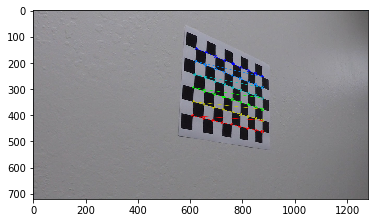

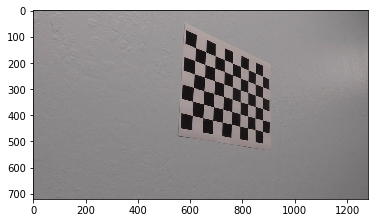

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

images = glob.glob('camera_cal/calibration*.jpg' )
print(len(images))


# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

objpoints=[]
imgpoints=[]



objp=np.zeros((ny*nx, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for fname in images:
    image = plt.imread(fname)
    #Convert image to Grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    #Find the chesboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        plt.imshow(image)
        
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

image = cv2.imread(images[-1])
undistorted = cal_undistort(image, objpoints, imgpoints)

plt.figure()
plt.imshow(undistorted)

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to the test images:

8


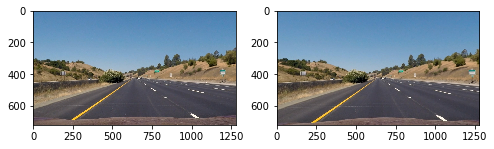

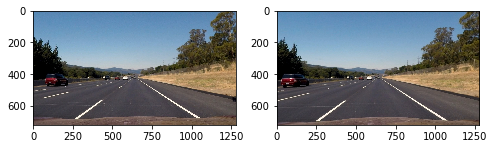

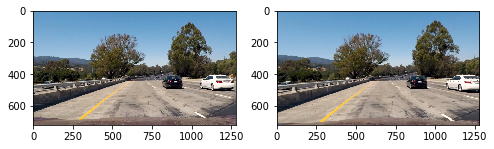

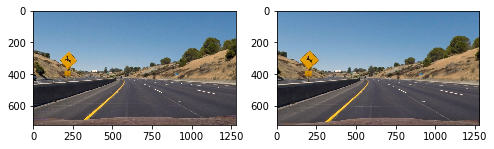

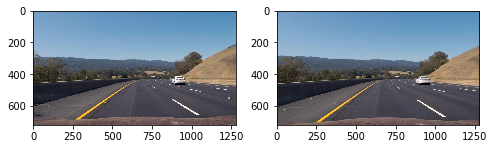

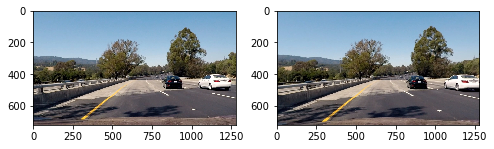

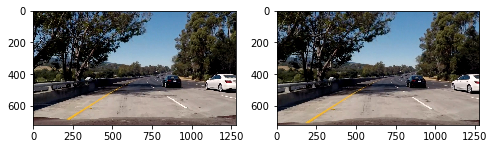

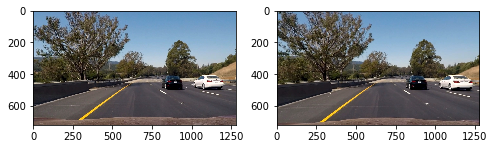

In [3]:
testimgs = glob.glob('test_images/*.jpg')
print(len(testimgs))

for testimg in testimgs:
    plt.figure(figsize = [8, 4])
    image = plt.imread(testimg)
    plt.subplot(1, 2, 1)
    plt.imshow(image)    
    undistorted = cal_undistort(image, objpoints, imgpoints)
    plt.subplot(1, 2, 2)
    plt.imshow(undistorted)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image.  Here's an example of my output for this step.

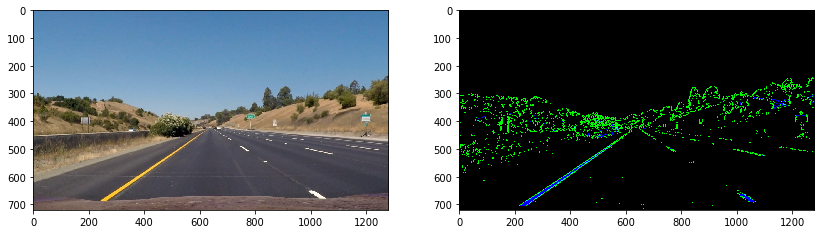

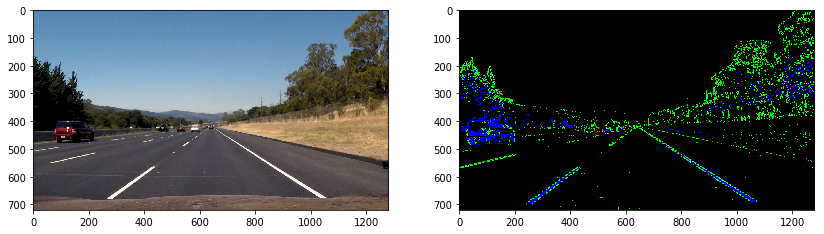

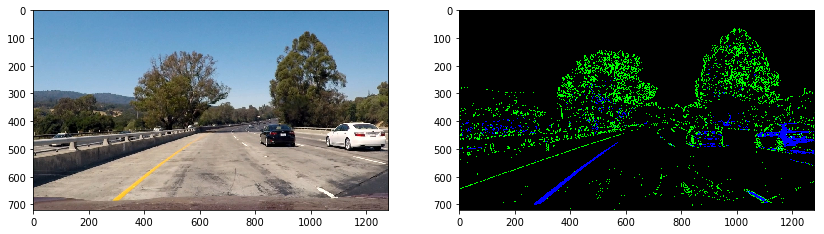

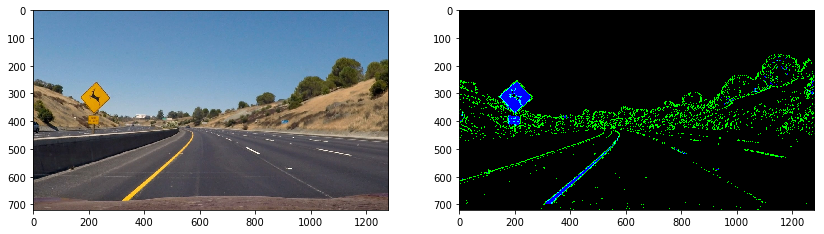

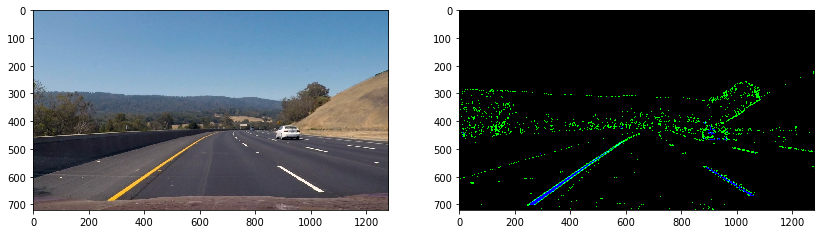

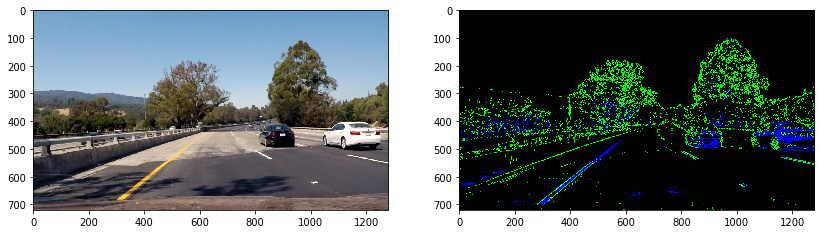

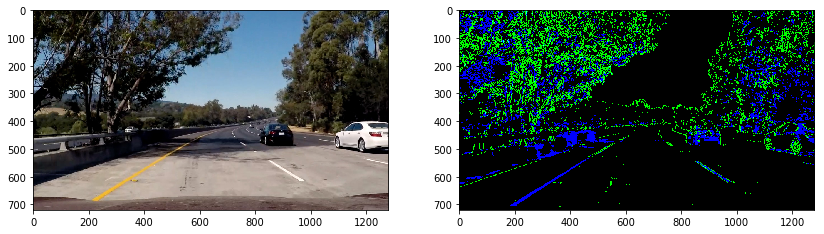

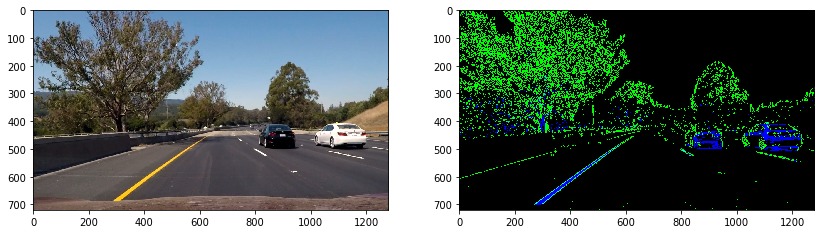

In [4]:
def transform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #(img, s_thresh=(190, 225), sx_thresh=(50, 70)):
    #(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    imghls = np.copy(img)
    hls = cv2.cvtColor(imghls, cv2.COLOR_RGB2HLS).astype(np.float)
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
 #   l_channel = hsv[:,:,1]
    s_channel = hls[:,:,2]
#    s_channel = hsv[:,:,1]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
#    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary, color_binary

for testimg in testimgs:
    plt.figure(figsize = [14, 7])
    image = plt.imread(testimg)
    plt.subplot(1, 2, 1)
    plt.imshow(image)    
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    plt.subplot(1, 2, 2)
    #plt.imshow(np.dstack((combined_binary*255, combined_binary*255, combined_binary*255)))
    plt.imshow(colored_binary)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`.  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:
```python
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100], #(-55 +100)
    [((img_size[0] / 6) -10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]]) #(+55)
dst = np.float32(
    [[(img_size[0] / 6), 0],
    [(img_size[0] / 6), img_size[1]],
    [(img_size[0] * 5 / 6), img_size[1]],
    [(img_size[0] * 5 / 6), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 213, 0        | 
| 203, 720      | 213, 720      |
| 1127, 720     | 1067, 720      |
| 705, 460      | 1067, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

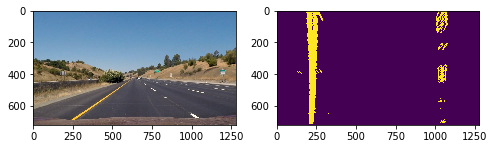

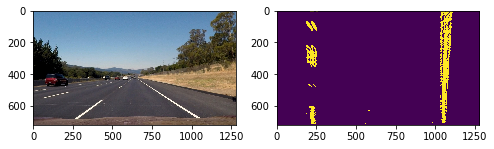

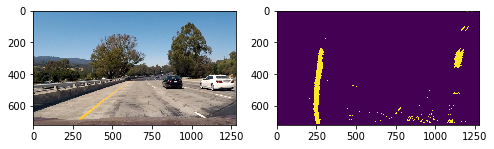

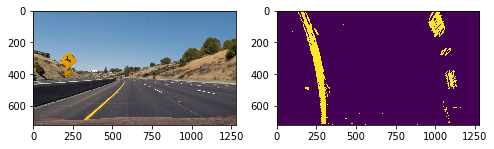

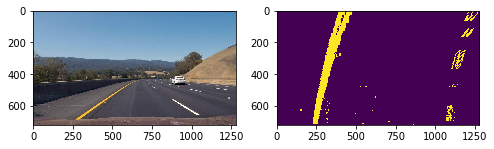

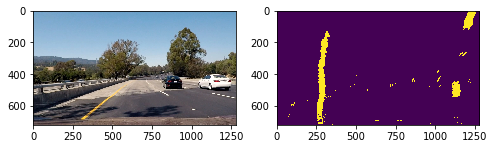

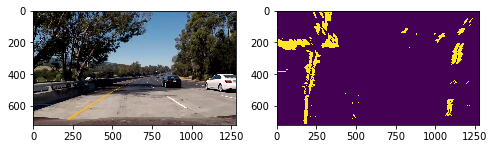

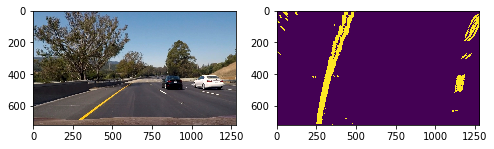

In [5]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100], #(-55 +100)
        [((img_size[0] / 6) -10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]]) #(+55)
    dst = np.float32(
        [[(img_size[0] / 6), 0],
        [(img_size[0] / 6), img_size[1]],
        [(img_size[0] * 5 / 6), img_size[1]],
        [(img_size[0] * 5 / 6), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


for testimg in testimgs:
    plt.figure(figsize = [8, 4])
    image = plt.imread(testimg)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)
    plt.subplot(1, 2, 2)
    plt.imshow(warped)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

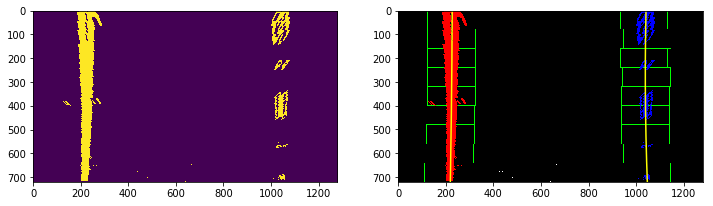

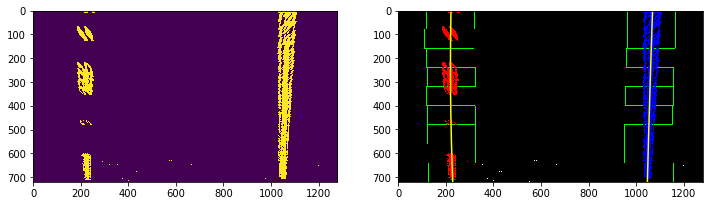

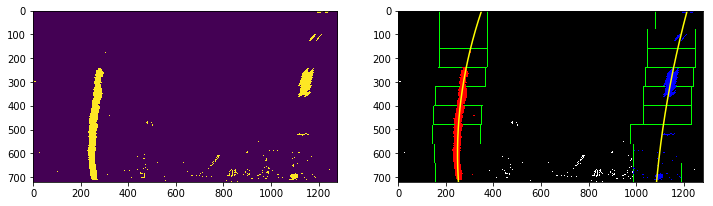

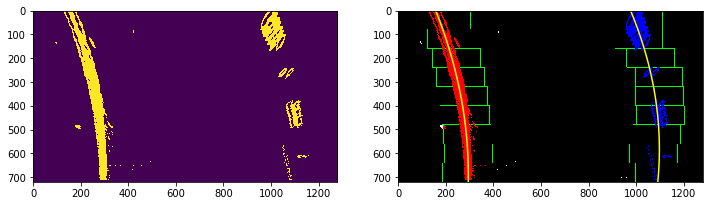

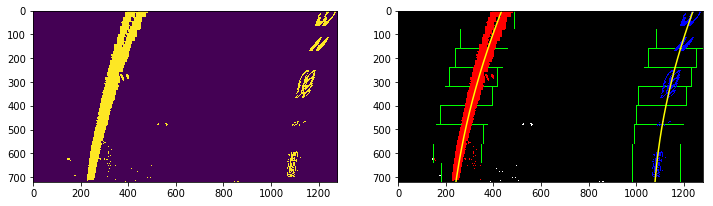

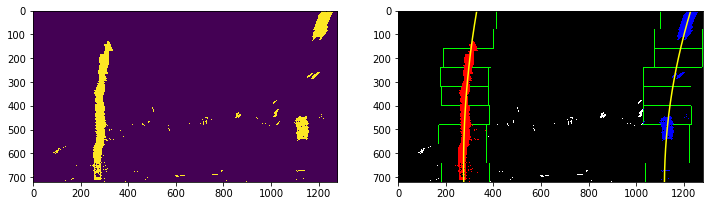

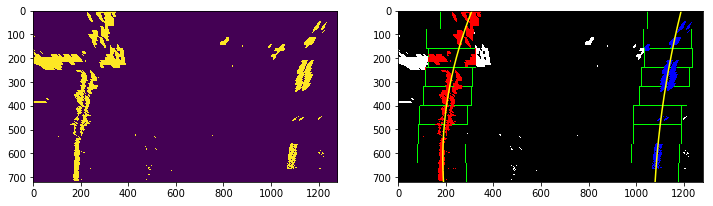

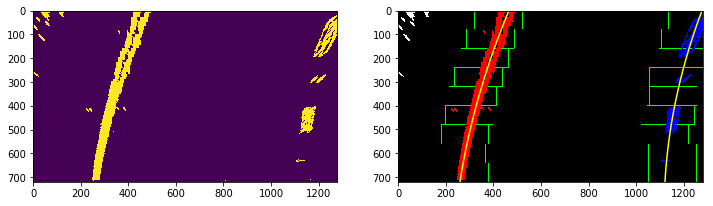

In [6]:


def find_lines_first(binary_warped):
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set the width of the windows +/- margin
    margin = 100
    # Choose the number of sliding windows
    nwindows = 9 #9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50 #50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

# Generate x and y values for plotting
for testimg in testimgs:
    image = plt.imread(testimg)
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = find_lines_first(warped)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.imshow(warped)
    #out_img = np.zeros_like (np.dstack((warped, warped, warped)))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.subplot(1, 2, 2)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

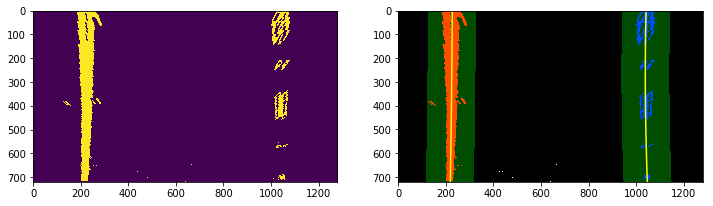

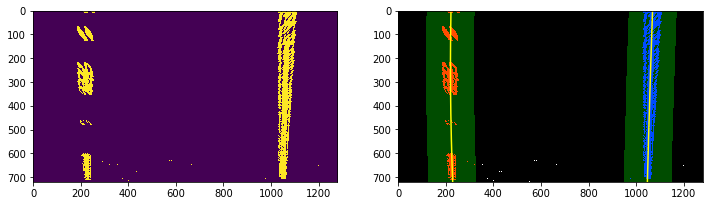

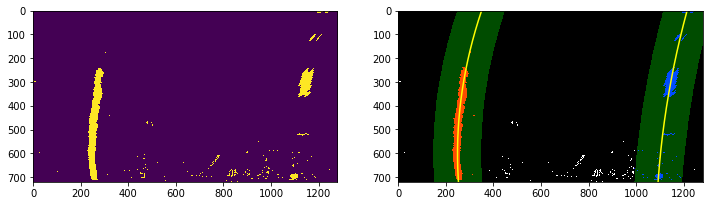

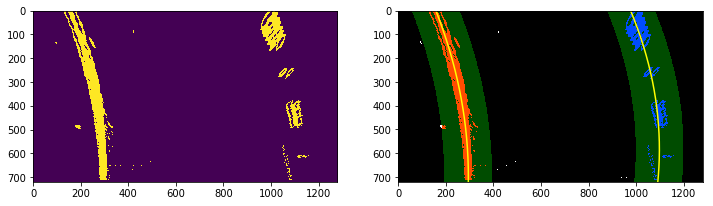

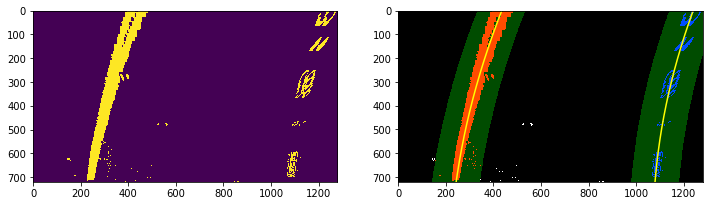

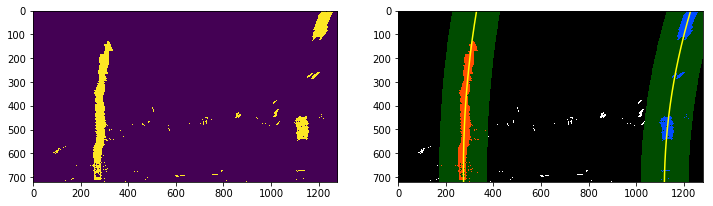

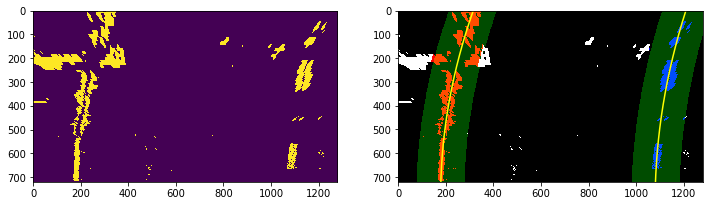

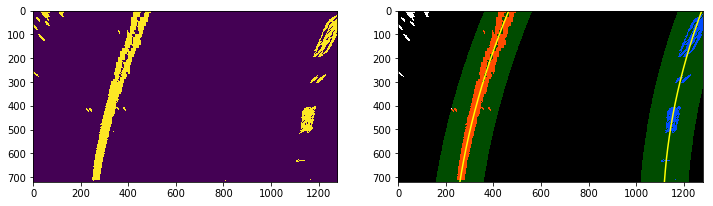

In [7]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def find_lines_other(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty


#visualize
for testimg in testimgs:
    image = plt.imread(testimg)
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)
    margin = 100
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = find_lines_first(warped)
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty = find_lines_other(warped, left_fit, right_fit)
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.imshow(warped)
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Next I've calculated the radius of the lane in code:

In [8]:
def curvature(left_fit, right_fit, leftx, rightx, ploty, midpoint):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#    print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/850
    # Fit new polynomials to x,y in world space
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curvature = round((left_curverad/2 + right_curverad/2), 2)
    offset = round(((leftx[1] + rightx[1])/2 - midpoint)* xm_per_pix, 2)
    #print(curvature, 'm ', offset)
    return curvature, offset
    
for testimg in testimgs:
    image = plt.imread(testimg)
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)
    midpoint = image.shape[1]/2
    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = find_lines_first(warped)
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty= find_lines_other(warped, left_fit, right_fit)

    curv, offset = curvature(left_fit, right_fit, left_fitx, right_fitx, ploty, midpoint)
    
    print(curv, 'm ', offset)

12710.57 m  -0.03
17739.16 m  -0.01
1065.61 m  0.14
635.98 m  0.23
1074.45 m  0.09
1292.84 m  0.25
949.81 m  -0.04
1039.11 m  0.21


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

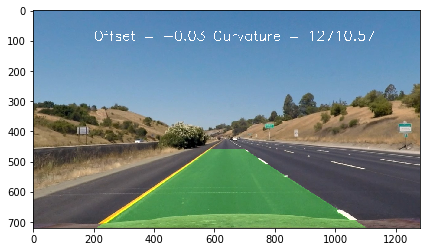

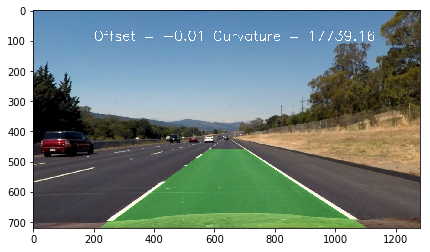

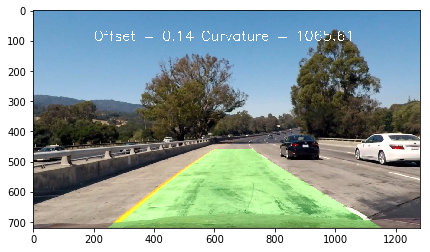

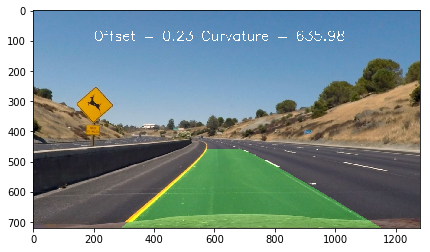

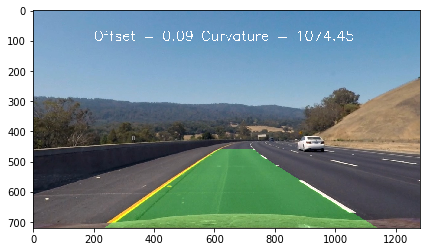

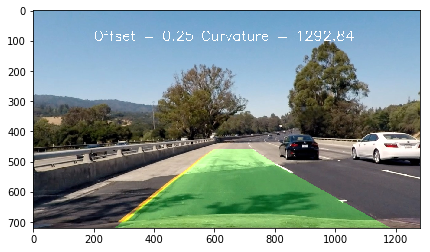

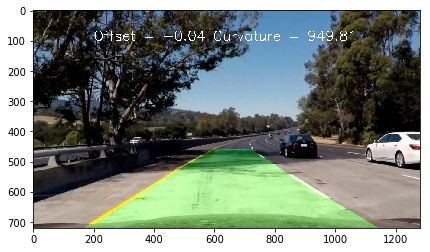

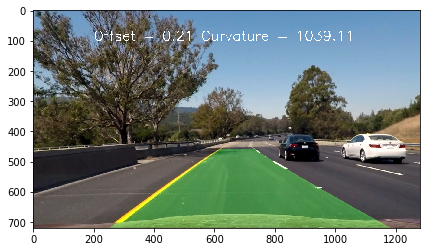

In [9]:
def drawing(image, warped, undist, left_fitx, right_fitx, ploty, curvature, offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100], #(-55 +100)
        [((img_size[0] / 6) -10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]]) #(+55)
    dst = np.float32(
        [[(img_size[0] / 6), 0],
        [(img_size[0] / 6), img_size[1]],
        [(img_size[0] * 5 / 6), img_size[1]],
        [(img_size[0] * 5 / 6), 0]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Offset = " + str(offset) + " Curvature = " + str(curvature)
    cv2.putText(result, text,(200,100), font, 1.5, (255,255,255), 2)
    return result

for testimg in testimgs:
    plt.figure(figsize = [8, 4])
    image = plt.imread(testimg)
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)

    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = find_lines_first(warped)
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty= find_lines_other(warped, left_fit, right_fit)
    
    midpoint = image.shape[1]/2
    curv, offset = curvature(left_fit, right_fit, left_fitx, right_fitx, ploty, midpoint)
    
    result = drawing(image, warped, undist, left_fitx, right_fitx, ploty, curv, offset)
    plt.imshow(result)

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4) project video.mp4. 

I have such a steps during calculating each frame:

-undistort

-transform to combined binary

-warp

-find lines

-mark lines

-smooth lines based on last 20 detections

-calculate curvature

-create result image with drawed lane

In [10]:
numiter = 0
smooth_left_fitx =[]
smooth_right_fitx =[]

def process_image(image):
    undist = cal_undistort(image, objpoints, imgpoints)
    combined_binary, colored_binary = transform(undist)
    warped = warp(combined_binary)

    left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = find_lines_first(warped)
    left_fitx, right_fitx, left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img, ploty= find_lines_other(warped, left_fit, right_fit)
    midpoint = image.shape[1]/2
    #print('in')
    smooth_left_fitx.append(left_fitx)
    smooth_right_fitx.append(right_fitx)
    if len(smooth_left_fitx) < 20 :
        left_fitx_sm = np.sum(smooth_left_fitx, axis=0)/len(smooth_left_fitx)
        right_fitx_sm = np.sum(smooth_right_fitx, axis=0)/len(smooth_right_fitx)
    else:
        left_fitx_sm = np.sum(smooth_left_fitx[-20 :], axis=0)/20
        right_fitx_sm = np.sum(smooth_right_fitx[-20 :], axis=0)/20
        
    #print(left_fitx_sm)
    curv, offset = curvature(left_fit, right_fit, left_fitx_sm, right_fitx_sm, ploty, midpoint)
    result = drawing(image, warped, undist, left_fitx_sm, right_fitx_sm, ploty, curv, offset)
    return result


## Test on Videos

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
white_output2 = 'test_videos_output/challenge_video.mp4'
white_output3 = 'test_videos_output/harder_challenge_video.mp4'

clip1 = VideoFileClip("project_video.mp4") #.subclip(0,5)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)
#print(len(smooth_left_fitx))

clip2 = VideoFileClip("challenge_video.mp4") #.subclip(0,5)
white_clip2 = clip2.fl_image(process_image) 
%time white_clip2.write_videofile(white_output2, audio=False)

clip3 = VideoFileClip("harder_challenge_video.mp4") #.subclip(0,5)
white_clip3 = clip3.fl_image(process_image) 
%time white_clip3.write_videofile(white_output3, audio=False)


[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [17:15<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 17min 16s
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [06:28<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 6min 29s
[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [39:03<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

Wall time: 39min 4s


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

Project went good with code bases on lessons. But after implementation I had a problem with finding correct lines and shadows on the road. Also sometimes detection is wrong. 

I've focused on detection lines on the driven lane. So the warped area covers one lane with small marigin to the sides - this help avoid the detection of shoulders as the lane lines.

The tresholds could be changed to better suite areas with shadows and shoulders and walls near road.

The wrong frames impact has been minimised on the movie with making the mean value of last 20 detections.

I think the tresholding should be improved. I've tried different settings, also different chanels. Maybe the H chanell with settings to detect yellow and white color could give the correct result. I've tried S and V chanels and it didn't help (maybe need more tuning)